<a href="https://colab.research.google.com/github/Anjasfedo/data-analysis/blob/main/Predictive_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Predictive Analytic : Pima Indian Diabetes
- **Nama:** M. Anjasfedo Afridiansah
- **Email:** fedoafridiansah@gmail.com
- **ID Dicoding:** anjasfedo

# Import Libraries & Packages
Pada tahap ini, seluruh library yang dibutuhkan untuk analisis data dan modeling akan diimpor.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (confusion_matrix, accuracy_score, mean_squared_error,
                             r2_score, roc_auc_score, roc_curve, classification_report)
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

import missingno as msno
import warnings
warnings.simplefilter(action="ignore")
import joblib
import kagglehub

# Data Collection

Pada tahap ini, data diunduh dari Kaggle dan dimuat ke dalam dataframe. Dataset yang digunakan adalah *Pima Indian Diabetes Dataset* yang berisi data klinis pasien perempuan keturunan Indian Pima.

In [2]:
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")
print("Path to dataset files:", path)

df = pd.read_csv(f"{path}/diabetes.csv")
df.info()

Path to dataset files: /kaggle/input/pima-indians-diabetes-database
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Setelah data berhasil dimuat, diketahui bahwa dataset terdiri dari 768 baris dan 9 kolom, tanpa nilai kosong secara eksplisit pada tahap awal karena semua kolom terisi. Namun, beberapa fitur seperti Glucose, BloodPressure, SkinThickness, Insulin, dan BMI bisa bernilai 0 yang secara medis tidak mungkin dan akan diperlakukan sebagai missing values pada tahap selanjutnya.

# Data Understanding

Tahapan ini bertujuan untuk memahami struktur dan kondisi awal data sebelum dilakukan pembersihan.

In [3]:
df.Outcome.value_counts()

,count
Outcome,
0,500
1,268


Ditemukan 500 sampel non-diabetes dan 268 sampel diabetes, sehingga data imbalance.

In [4]:
zero_counts = (df.drop(columns=['Outcome']) == 0).sum()
print(zero_counts)

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


Nilai 0 yang dianggap tidak valid ditemukan pada:
- Pregnancies: 111
- Glucose: 5
- BloodPressure: 35
- SkinThickness: 227
- Insulin: 374
- BMI: 11

(Nilainya akan diimputasi pada tahap berikutnya.)

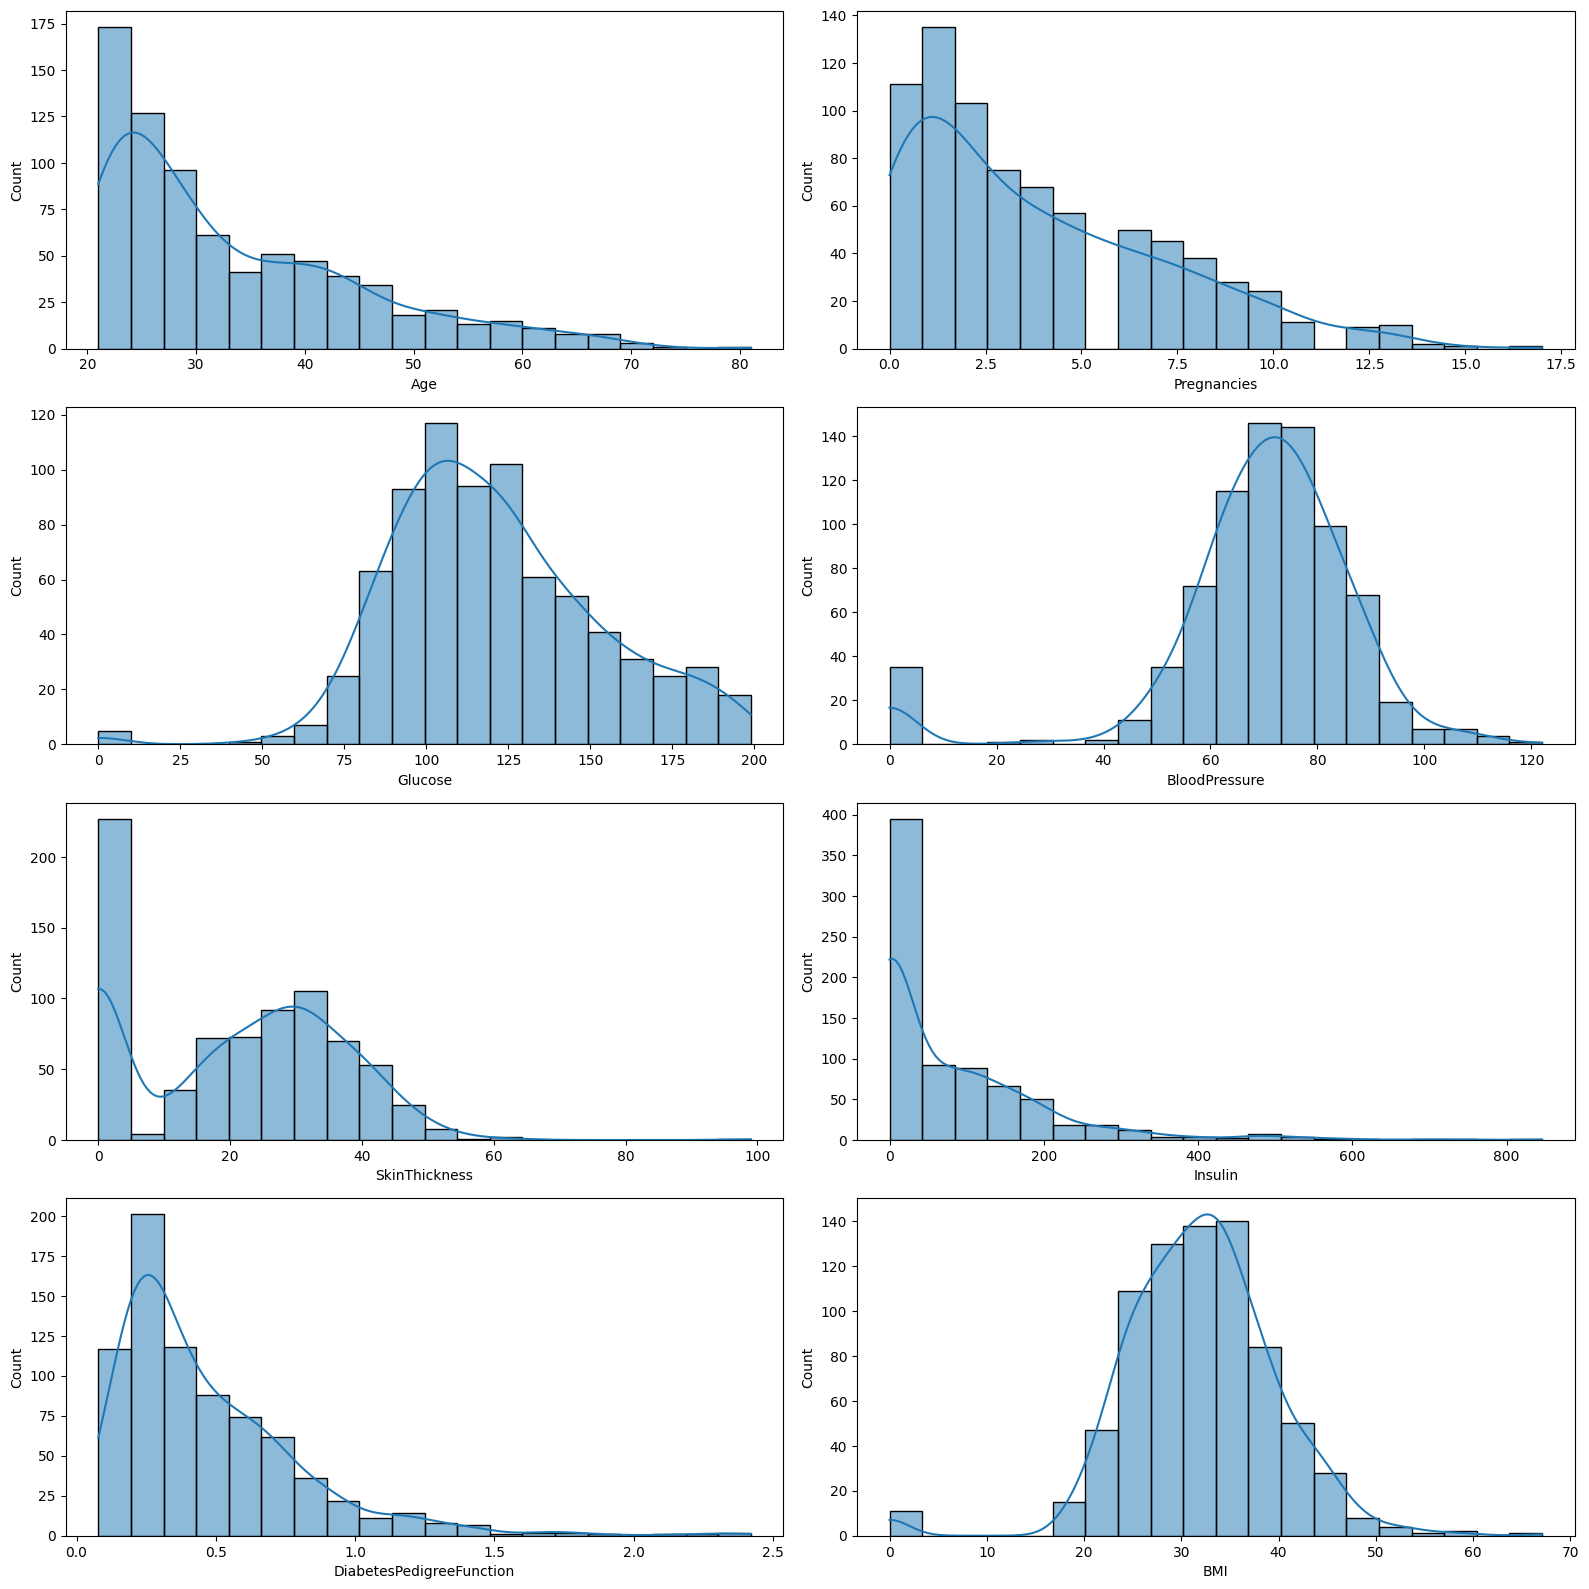

In [5]:
fig, ax = plt.subplots(4, 2, figsize=(16, 16))
features = [
    "Age", "Pregnancies", "Glucose", "BloodPressure",
    "SkinThickness", "Insulin", "DiabetesPedigreeFunction", "BMI"
]

for i, feature in enumerate(features):
    row, col = divmod(i, 2)
    sns.histplot(df[feature], bins=20, ax=ax[row, col], kde=True)
plt.tight_layout()
plt.show()

In [6]:
def detect_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = ((data[feature] < lower_bound) | (data[feature] > upper_bound)).sum()
    return outlier_count

outlier_summary = {}
for feature in features:
    outlier_summary[feature] = detect_outliers_iqr(df, feature)

outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Jumlah Outlier'])
print("Jumlah outlier pada setiap fitur (metode IQR):")
display(outlier_df)

Jumlah outlier pada setiap fitur (metode IQR):


,Jumlah Outlier
Age,9
Pregnancies,4
Glucose,5
BloodPressure,45
SkinThickness,1
Insulin,34
DiabetesPedigreeFunction,29
BMI,19


Fitur yang memiliki outlier terbanyak adalah BloodPressure (45 data), diikuti oleh Insulin (34 data), DiabetesPedigreeFunction (29 data), dan BMI (19 data). Outlier juga ditemukan pada fitur Age (9 data), Glucose (5 data), Pregnancies (4 data), dan SkinThickness (1 data). Jumlah outlier yang cukup signifikan pada beberapa fitur perlu diperhatikan dalam proses data preparation, agar tidak mempengaruhi hasil prediksi model secara negatif.

In [7]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


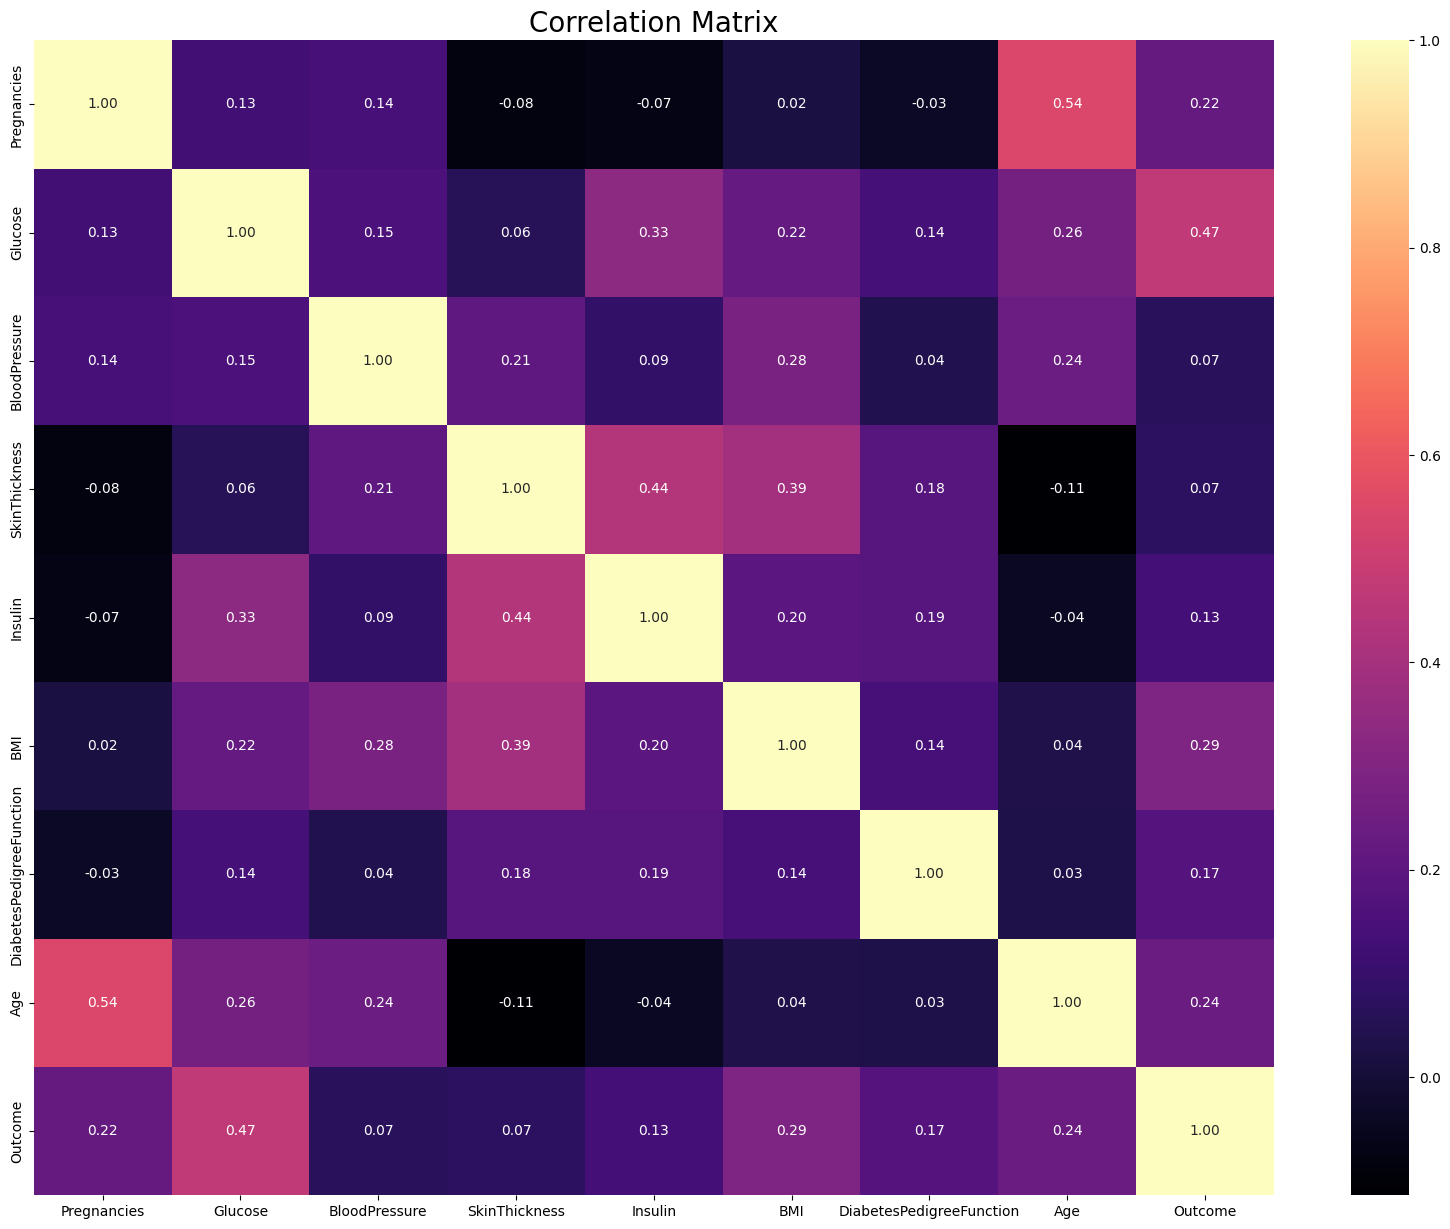

In [8]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

- Korelasi tertinggi terhadap target Outcome adalah pada fitur Glucose (0.47), diikuti oleh BMI (0.29), Age (0.24), dan Pregnancies (0.22). Artinya, kadar glukosa darah pasien memiliki hubungan paling kuat terhadap kejadian diabetes pada dataset ini.
- Fitur-fitur lain memiliki korelasi lemah hingga sedang terhadap outcome, yang berarti model prediksi diabetes perlu mempertimbangkan banyak faktor bukan hanya satu fitur saja.
- Korelasi antar fitur relatif tidak terlalu tinggi. Hanya beberapa fitur seperti SkinThickness dan Insulin (0.44), dan Age dan Pregnancies (0.54) yang memiliki korelasi moderat.
- Tidak ditemukan multikolinearitas ekstrim, sehingga seluruh fitur masih dapat digunakan untuk modeling setelah proses feature selection/engineering jika diperlukan.

# Data Preparation
Pada tahap ini, dilakukan pembersihan dan penyiapan data sebelum digunakan untuk proses modeling.

### Mising Value
Beberapa fitur seperti Glucose, BloodPressure, SkinThickness, Insulin, dan BMI memiliki nilai 0 yang secara medis tidak mungkin, sehingga nilai 0 tersebut telah diganti dengan `NaN` dan akan diimputasi. Imputasi dilakukan dengan menggunakan nilai median dari masing-masing fitur karena data memiliki distribusi yang tidak simetris (terdapat outlier).

In [9]:
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)

In [10]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [11]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


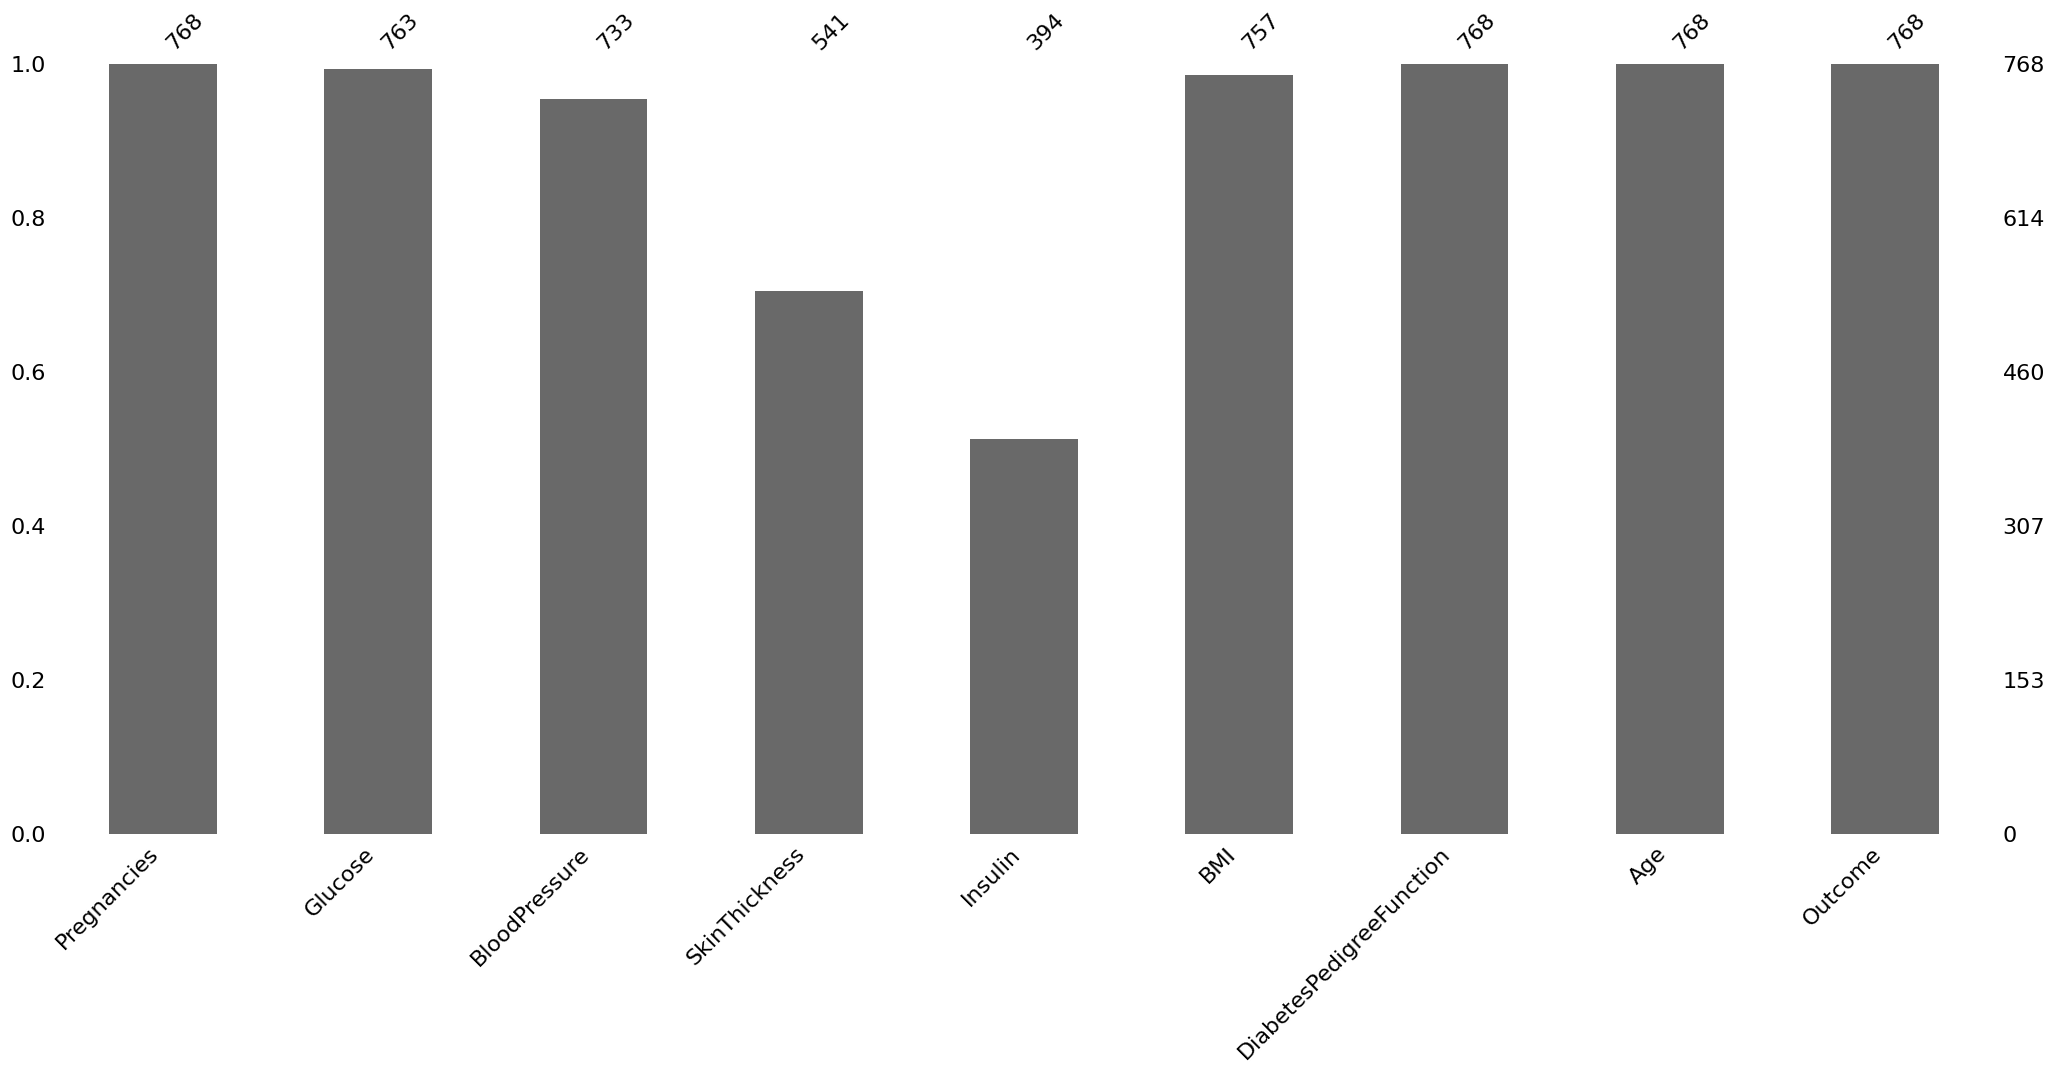

In [12]:
msno.bar(df);

In [13]:
def median_target(var):
    temp = df[df[var].notnull()]
    temp = temp.groupby('Outcome')[[var]].median().reset_index()
    return temp

In [14]:
columns = df.columns.drop("Outcome")
for col in columns:
    medians = median_target(col)
    df.loc[(df['Outcome'] == 0) & (df[col].isnull()), col] = medians[col][0]
    df.loc[(df['Outcome'] == 1) & (df[col].isnull()), col] = medians[col][1]

In [15]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [16]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


### Outlier
Setelah imputasi missing value, outlier yang terdeteksi pada fitur numerik perlu ditangani agar tidak mempengaruhi hasil modeling secara signifikan. Penanganan dapat dilakukan dengan metode capping menggunakan batas bawah dan atas dari IQR (Winsorization).

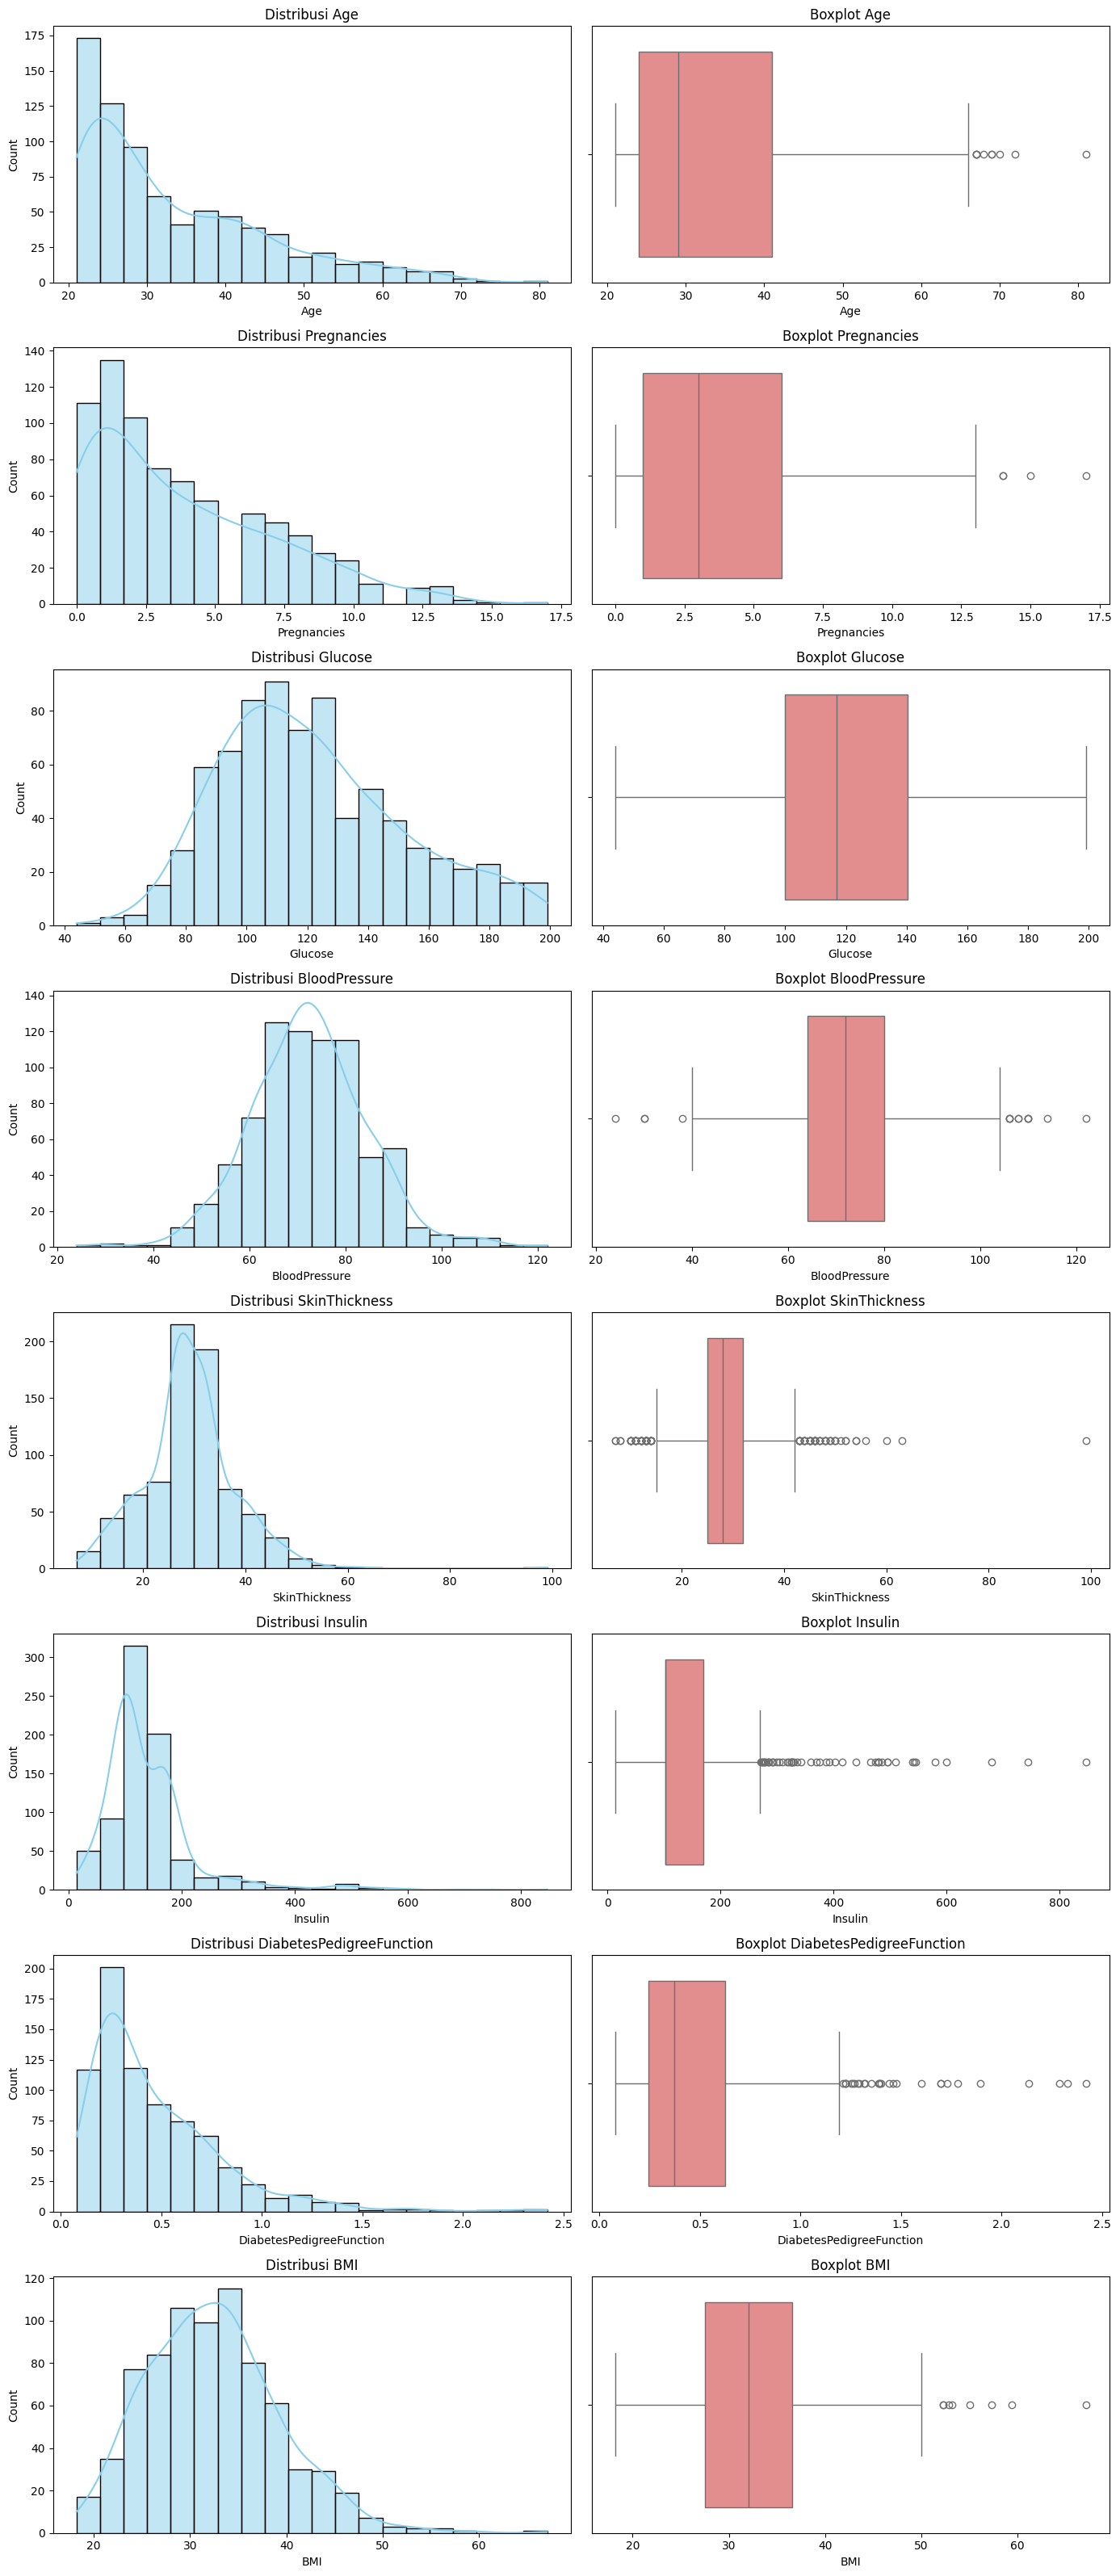

In [17]:
features = [
    "Age", "Pregnancies", "Glucose", "BloodPressure",
    "SkinThickness", "Insulin", "DiabetesPedigreeFunction", "BMI"
]

fig, axs = plt.subplots(8, 2, figsize=(14, 32))

for i, feature in enumerate(features):
    sns.histplot(df[feature], bins=20, ax=axs[i, 0], kde=True, color='skyblue')
    axs[i, 0].set_title(f'Distribusi {feature}')

    sns.boxplot(x=df[feature], ax=axs[i, 1], color='lightcoral')
    axs[i, 1].set_title(f'Boxplot {feature}')

plt.tight_layout()
plt.show()

In [18]:
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

outlier_cols = ["Age", "Pregnancies", "Glucose", "BloodPressure",
    "SkinThickness", "Insulin", "DiabetesPedigreeFunction", "BMI"]

for col in outlier_cols:
    cap_outliers(df, col)

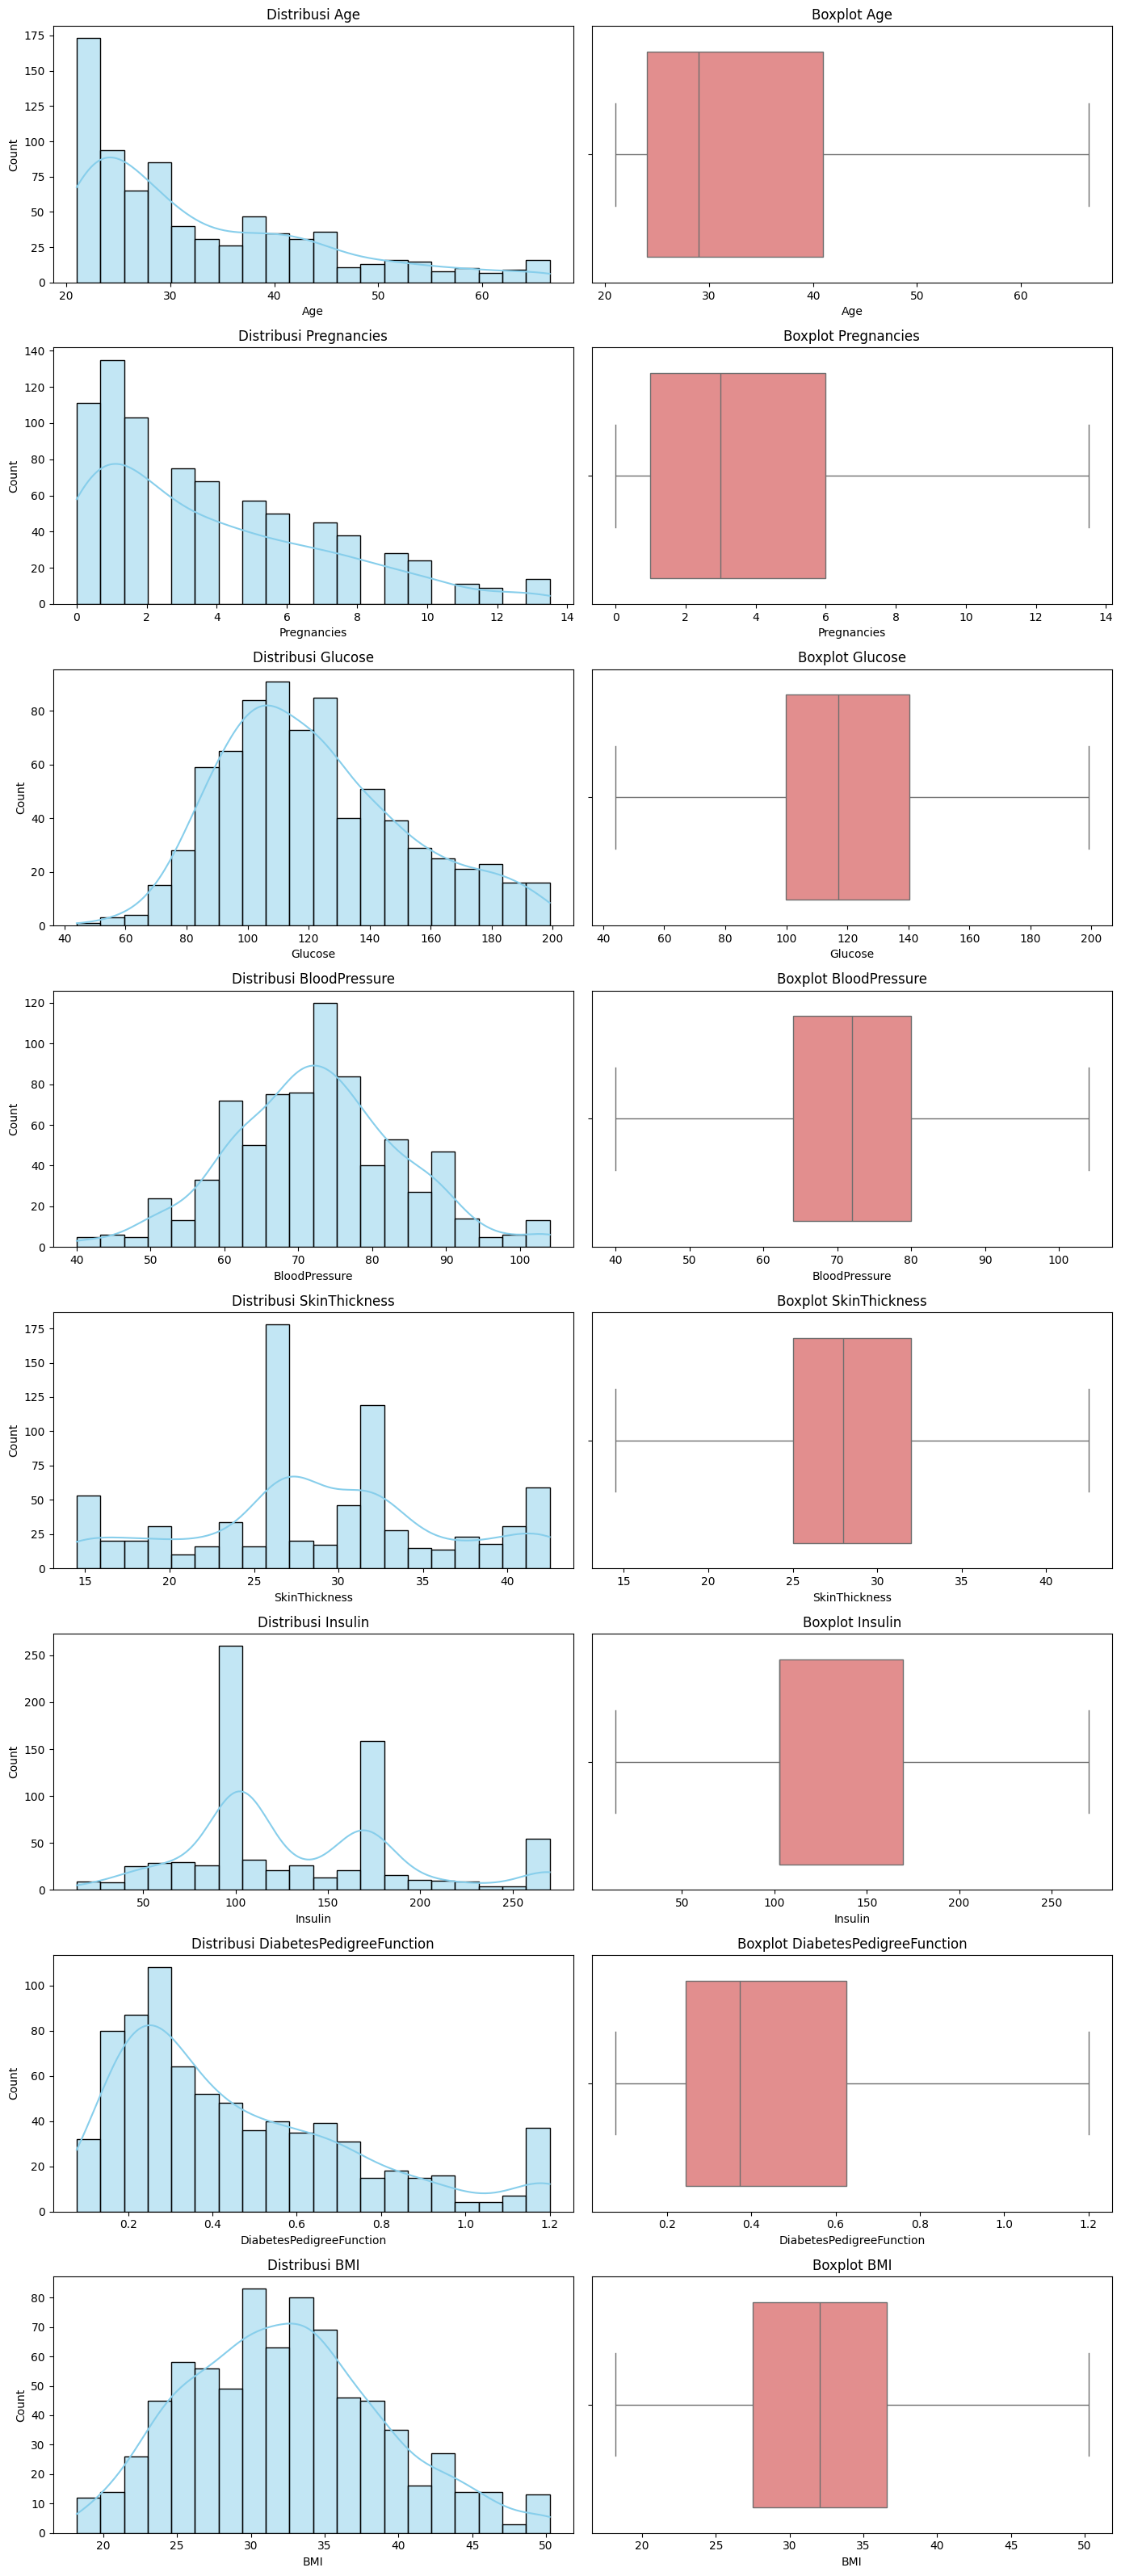

In [19]:
features = [
    "Age", "Pregnancies", "Glucose", "BloodPressure",
    "SkinThickness", "Insulin", "DiabetesPedigreeFunction", "BMI"
]

fig, axs = plt.subplots(8, 2, figsize=(14, 32))

for i, feature in enumerate(features):
    sns.histplot(df[feature], bins=20, ax=axs[i, 0], kde=True, color='skyblue')
    axs[i, 0].set_title(f'Distribusi {feature}')

    sns.boxplot(x=df[feature], ax=axs[i, 1], color='lightcoral')
    axs[i, 1].set_title(f'Boxplot {feature}')

plt.tight_layout()
plt.show()

## Feature Engineering
Pada tahap ini, dilakukan pembuatan fitur baru dari fitur numerik yang sudah ada agar model dapat menangkap pola yang mungkin tidak terlihat hanya dari nilai mentah.

In [20]:
bmi_categories = {
    "Underweight": lambda x: x < 18.5,
    "Normal": lambda x: 18.5 <= x <= 24.9,
    "Overweight": lambda x: 24.9 < x <= 29.9,
    "Obesity 1": lambda x: 29.9 < x <= 34.9,
    "Obesity 2": lambda x: 34.9 < x <= 39.9,
    "Obesity 3": lambda x: x > 39.9
}

def categorize_bmi(bmi):
    for category, condition in bmi_categories.items():
        if condition(bmi):
            return category
    return None

df["NewBMI"] = df["BMI"].apply(categorize_bmi).astype("category")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1,Obesity 1
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0,Overweight
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1,Normal
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,Overweight
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1,Obesity 3


In [21]:
insulin_categories = {
    "Normal": lambda x: 16 <= x <= 166,
    "Abnormal": lambda x: x < 16 or x > 166
}

def categorize_insulin(insulin):
    for category, condition in insulin_categories.items():
        if condition(insulin):
            return category
    return None

df["NewInsulin"] = df["Insulin"].apply(categorize_insulin).astype("category")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulin
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1,Obesity 1,Abnormal
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0,Overweight,Normal
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1,Normal,Abnormal
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,Overweight,Normal
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1,Obesity 3,Abnormal


In [22]:
glucose_categories = {
    "Low": lambda x: x <= 70,
    "Normal": lambda x: 70 < x <= 99,
    "Overweight": lambda x: 99 < x <= 126,
    "Secret": lambda x: x > 126
}

def categorize_glucose(glucose):
    for category, condition in glucose_categories.items():
        if condition(glucose):
            return category
    return None

df["NewGlucose"] = df["Glucose"].apply(categorize_glucose).astype("category")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulin,NewGlucose
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1,Obesity 1,Abnormal,Secret
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0,Overweight,Normal,Normal
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1,Normal,Abnormal,Secret
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,Overweight,Normal,Normal
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1,Obesity 3,Abnormal,Secret


Feature engineering ini bertujuan memperkaya representasi data sehingga model machine learning dapat menangkap pola dengan lebih baik, terutama pada fitur-fitur kunci seperti BMI, Insulin, dan Glucose yang sangat erat kaitannya dengan risiko diabetes.

## One Hot Encoding

Pada tahap ini dilakukan konversi fitur kategorikal hasil feature engineering menjadi fitur numerik agar dapat digunakan oleh model machine learning. Proses ini dikenal sebagai One Hot Encoding.


In [23]:
df = pd.get_dummies(df, columns=["NewBMI", "NewInsulin", "NewGlucose"])

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI_Normal,...,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulin_Abnormal,NewInsulin_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1,False,...,False,False,False,False,True,False,False,False,False,True
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0,False,...,False,False,True,False,False,True,False,True,False,False
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1,True,...,False,False,False,False,True,False,False,False,False,True
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,False,...,False,False,True,False,False,True,False,True,False,False
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1,False,...,False,True,False,False,True,False,False,False,False,True


In [24]:
categorical_df = df[[
    'NewBMI_Obesity 1', 'NewBMI_Obesity 2', 'NewBMI_Obesity 3',
    'NewBMI_Overweight', 'NewBMI_Underweight', 'NewBMI_Normal',
    'NewInsulin_Normal', "NewInsulin_Abnormal",
    'NewGlucose_Low', 'NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret'
]]

categorical_df.head()

,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewBMI_Normal,NewInsulin_Normal,NewInsulin_Abnormal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
0,True,False,False,False,False,False,False,True,False,False,False,True
1,False,False,False,True,False,False,True,False,False,True,False,False
2,False,False,False,False,False,True,False,True,False,False,False,True
3,False,False,False,True,False,False,True,False,False,True,False,False
4,False,False,True,False,False,False,False,True,False,False,False,True


In [25]:
y = df["Outcome"]

drop_cols = [
    'NewBMI_Obesity 1', 'NewBMI_Obesity 2', 'NewBMI_Obesity 3',
    'NewBMI_Overweight', 'NewBMI_Underweight', 'NewBMI_Normal',
    'NewInsulin_Normal',  "NewInsulin_Abnormal",
    'NewGlucose_Low', 'NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret'
]

X = df.drop(["Outcome"] + drop_cols, axis=1)

cols = X.columns
index = X.index

X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0
4,0.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0


### Feature Scaling
Seluruh fitur numerik pada `X` dilakukan scaling menggunakan `RobustScaler` agar model tidak bias terhadap fitur dengan skala besar dan lebih robust terhadap outlier.

In [26]:
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns=cols, index=index)

X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.6,0.765432,0.000,1.000000,1.000000,0.170330,0.665359,1.235294
1,-0.4,-0.790123,-0.375,0.142857,0.000000,-0.598901,-0.056209,0.117647
2,1.0,1.629630,-0.500,0.571429,1.000000,-0.961538,0.783007,0.176471
3,-0.4,-0.691358,-0.375,-0.714286,-0.126866,-0.434066,-0.537255,-0.470588
4,-0.6,0.493827,-2.000,1.000000,0.977612,1.214286,2.163399,0.235294


## Split Data
Tahap ini bertujuan untuk membagi dataset menjadi dua bagian utama, yaitu data latih train dan data uji test.

Proporsi data uji adalah 20% dan data latih 80%


In [27]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling
Pada tahap ahap modeling data yang telah dipersiapkan digunakan untuk membangun model machine learning. Tujuan utama dari tahap ini adalah mencari model dan pengaturan parameter (hyperparameter) yang menghasilkan prediksi terbaik terhadap risiko diabetes pada pasien berdasarkan fitur-fitur yang telah tersedia.

## Grid Search CV
Pada tahap ini dilakukan pemilihan model terbaik dan tuning hyperparameter menggunakan Grid Search Cross Validation (Grid Search CV) pada algoritma XGBoost Classifier. Grid Search CV adalah metode pencarian otomatis untuk kombinasi hyperparameter terbaik berdasarkan evaluasi kinerja model secara cross-validation.

 - `param_grid` berisi kombinasi nilai hyperparameter yang akan diuji, seperti:
     - `learning_rate`: Mengatur kecepatan model dalam belajar.
     - `max_depth`: Kedalaman maksimum pohon keputusan.
     - `n_estimators`: Jumlah pohon yang akan dibangun.
     - `subsample`: Proporsi data yang digunakan untuk setiap pohon.
     - `colsample_bytree`: Proporsi fitur yang digunakan untuk setiap pohon.
   - Dengan grid tersebut, Grid Search akan mencoba semua kombinasi yang mungkin.

   Model yang digunakan adalah `XGBClassifier` dari library XGBoost.

In [28]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("Best Parameters Found:")
print(grid_search.best_params_)

print("\nBest Cross-Validation Score:")
print(grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters Found:
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}

Best Cross-Validation Score:
0.9023324003731841


## Model Best Parameter
Model XGBoost kemudian dibuat ulang dan dilatih pada data train menggunakan parameter terbaik hasil pencarian Grid Search.

In [29]:
best_params = grid_search.best_params_

xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    **best_params
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# Evaluation
Pada tahap evaluasi, performa model yang telah dibangun diukur menggunakan data uji (test set) yang belum pernah dilihat oleh model selama proses pelatihan. Evaluasi memastikan model tidak hanya baik pada data latih, tetapi juga mampu melakukan prediksi yang akurat pada data baru.

## Classification Report
- Classification Report adalah rangkuman metrik evaluasi klasifikasi yang meliputi:
  - Accuracy: Persentase prediksi yang benar dari seluruh prediksi.
  - Precision: Ketepatan model dalam memprediksi kelas positif (berapa banyak prediksi positif yang benar).
  - Recall (Sensitivity): Kemampuan model dalam menemukan semua kasus positif yang sebenarnya.
  - F1-Score: Rata-rata harmonis dari precision dan recall, berguna jika distribusi kelas tidak seimbang.

  Laporan ini memudahkan analisis kekuatan dan kelemahan model untuk masing-masing kelas (diabetes dan non-diabetes).


In [30]:
y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        99
           1       0.82      0.76      0.79        55

    accuracy                           0.86       154
   macro avg       0.85      0.84      0.84       154
weighted avg       0.86      0.86      0.86       154



## Confusion Matrix
- Confusion Matrix adalah tabel yang menggambarkan jumlah prediksi benar dan salah untuk masing-masing kelas:
  - True Positive (TP): Model benar memprediksi positif (diabetes).
  - True Negative (TN): Model benar memprediksi negatif (tidak diabetes).
  - False Positive (FP): Model salah memprediksi positif (sebenarnya negatif).
  - False Negative (FN): Model salah memprediksi negatif (sebenarnya positif).

  Visualisasi confusion matrix membantu mengetahui tipe kesalahan apa yang paling sering dilakukan model, serta keseimbangan performa antara deteksi positif dan negatif.

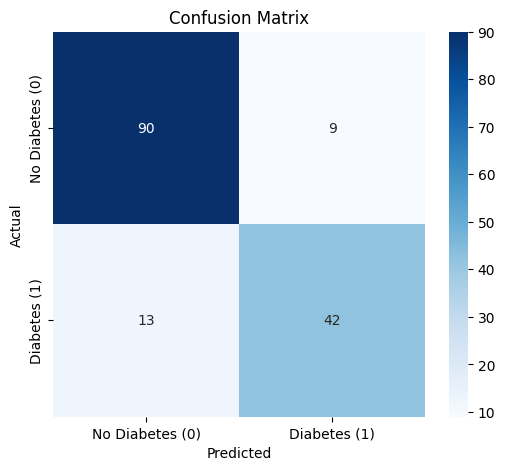

In [31]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['No Diabetes (0)', 'Diabetes (1)'],
    yticklabels=['No Diabetes (0)', 'Diabetes (1)']
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()